In [2]:
from sys import path

problem_dir = '../generators/'  
path.append(problem_dir)
%matplotlib inline

In [3]:
from sklearn import datasets
import numpy as np

centers = [(-1, -1), (5, 5)]
X, y = datasets.make_blobs(n_samples=100, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)

print('Data = Gaussian Isotropic blobs in 2D(clusters).')
print('X: %d data points in %dD.' % X.shape)
print('y: cluster of each data point.')

Data = Gaussian Isotropic blobs in 2D(clusters).
X: 100 data points in 2D.
y: cluster of each data point.


In [22]:
def blob_plot(ax, x, y, title, **params):
    ax.scatter(x, y, **params)
    ax.set_title(title)
    ax.axhline(0, color='k')
    ax.axvline(0, color='k')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    
def kde_plot(ax, xx, yy, x1min, x1max, x2min, x2max, f, title, **params):
    ax.set_xlim(x1min, x1max)
    ax.set_ylim(x2min, x2max)
    cfset = ax.contourf(xx, yy, f, cmap='Blues')
    cset = ax.contour(xx, yy, f, colors='k')
    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Kernel Density Estimation - Scipy \n Bandwidth = {:0.2f}'.format(bandwidth))

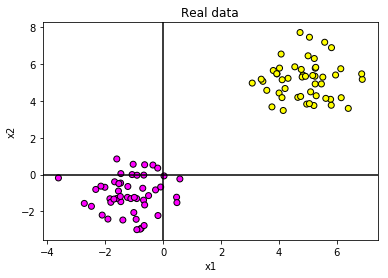

In [16]:
import matplotlib.pyplot as plt
import pylab

fig, ax = plt.subplots()
blob_plot(ax, X[:, 0], X[:, 1], title='Real data', c=y, cmap=pylab.cm.spring, edgecolors='k')

In [18]:
from sklearn.preprocessing import LabelEncoder 
from copula_generator import matrix_to_rank
     
X_rank = matrix_to_rank(X)

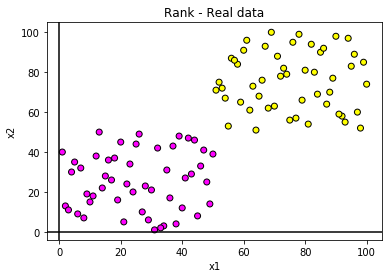

In [20]:
fig, ax = plt.subplots()
blob_plot(ax, X_rank[:, 0], X_rank[:, 1], title='Rank - Real data', c=y, cmap=pylab.cm.spring, edgecolors='k')

In [8]:
from scipy.stats import norm
from copula_generator import rank_matrix_to_inverse

X_inverse = rank_matrix_to_inverse(X_rank)

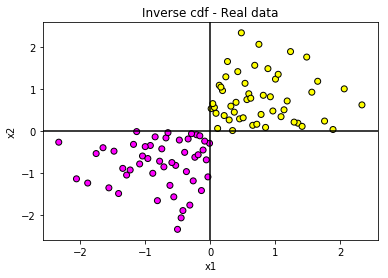

In [21]:
fig, ax = plt.subplots()
blob_plot(ax, X_inverse[:, 0], X_inverse[:, 1], title='Inverse cdf - Real data', c=y, cmap=pylab.cm.spring, edgecolors='k')

In [39]:
import scipy.stats as st
from sklearn.neighbors import KernelDensity

x1 = X_inverse[:, 0]
x2 = X_inverse[:, 1]

x1min = x1.min()
x1max = x1.max()
x2min = x2.min()
x2max = x2.max()

#  Kernel density parameter bandwidth between 0 and 1.
bandwidth = 0.1

# KDE using Scipy.
kernel_sc = st.gaussian_kde(np.vstack([x1, x2]), bw_method=bandwidth)

# KDE using Sklearn.
kernel_sk = KernelDensity(bandwidth=bandwidth).fit(np.vstack([x1, x2]).T)

Text(0.5,1,'Kernel Density Estimation - Sklearn \n Bandwidth = 0.10')

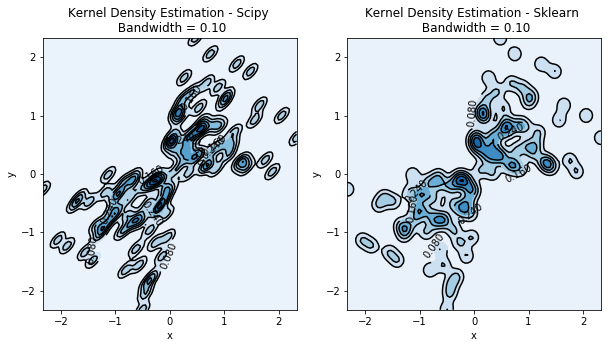

In [40]:
# Grid of points to plot the 2D distribution.
xx, yy = np.mgrid[x1min:x1max:100j, x2min:x2max:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
# Estimate the grid of points using the density estimations.
f_sc = np.reshape(kernel_sc(positions).T, xx.shape)
f_sk = np.reshape(np.exp(kernel_sk.score_samples(positions.T)), xx.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_xlim(x1min, x1max)
ax[0].set_ylim(x2min, x2max)
cfset = ax[0].contourf(xx, yy, f_sc, cmap='Blues')
cset = ax[0].contour(xx, yy, f_sc, colors='k')
ax[0].clabel(cset, inline=1, fontsize=10)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Kernel Density Estimation - Scipy \n Bandwidth = {:0.2f}'.format(bandwidth))

ax[1].set_xlim(x1min, x1max)
ax[1].set_ylim(x2min, x2max)
cfset = ax[1].contourf(xx, yy, f_sk, cmap='Blues')
cset = ax[1].contour(xx, yy, f_sk, colors='k')
ax[1].clabel(cset, inline=1, fontsize=10)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Kernel Density Estimation - Sklearn \n Bandwidth = {:0.2f}'.format(bandwidth))

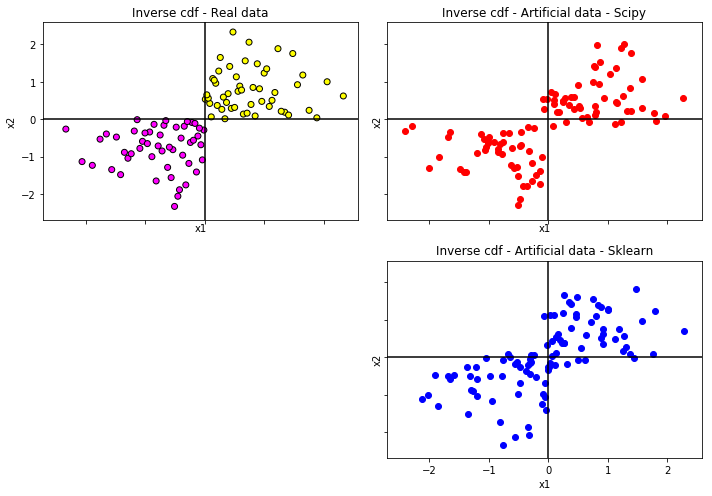

In [41]:
X_artif_sc = kernel_sc.resample(100)
X_artif_sk = kernel_sk.sample(100)

fig, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)
blob_plot(ax[0, 0], X_inverse[:, 0], X_inverse[:, 1], title='Inverse cdf - Real data', \
            c=y, cmap=pylab.cm.spring, edgecolors='k')
blob_plot(ax[0, 1], X_artif_sc[0, :], X_artif_sc[1, :], title='Inverse cdf - Artificial data - Scipy', \
            c='r')
blob_plot(ax[1, 1], X_artif_sk[:, 0], X_artif_sk[:, 1], title='Inverse cdf - Artificial data - Sklearn', \
            c='b')
ax[1, 0].axis('off')
plt.tight_layout()

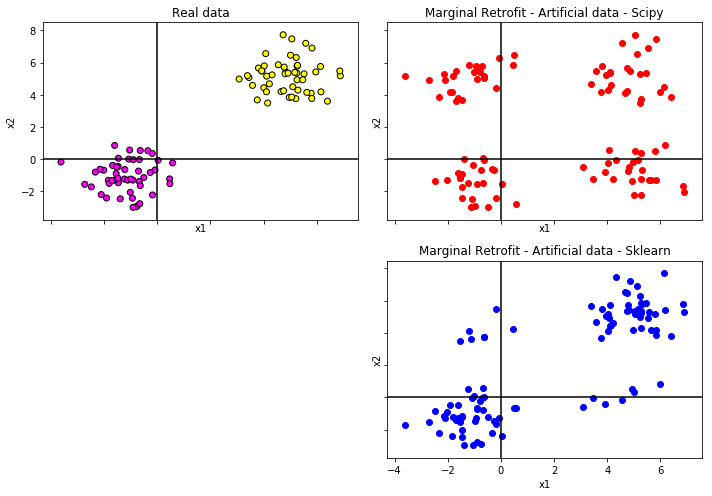

In [42]:
from copula_generator import marginal_retrofit

X_retrofit_sc = marginal_retrofit(X_artif_sc.T, X)
X_retrofit_sk = marginal_retrofit(X_artif_sk, X)

fig, ax = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)
custom_plot(ax[0, 0], X[:, 0], X[:, 1], title='Real data', \
            c=y, cmap=pylab.cm.spring, edgecolors='k')
custom_plot(ax[0, 1], X_retrofit_sc[:, 0], X_retrofit_sk[:, 1], title='Marginal Retrofit - Artificial data - Scipy', \
            c='r')
ax[1, 0].axis('off')
custom_plot(ax[1, 1], X_retrofit_sk[:, 0], X_retrofit_sk[:, 1], title='Marginal Retrofit - Artificial data - Sklearn', \
            c='b')
plt.tight_layout()

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

# Grid search to find optimal bandwidth.
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.001, 10.0, 1000)},
                    cv=20)
grid.fit(np.vstack([x1, x2]).T)
print(grid.best_params_)

{'bandwidth': 0.3012702702702703}


In [35]:
from sys import path

generator_dir = '../generators/'
utils_dir = '../data_manager/'
path.append(problem_dir)
path.append(utils_dir)

from metric import *

print('Covariance discrepancy: ', cov_discrepancy(X, X_artif_sc.T))
print('Correlation discrepancy: ', corr_discrepancy(X, X_artif_sc.T))
print('Relief divergence: ', relief_divergence(X, X_artif_sc.T))
print('KS_test: ', ks_test(X, X_artif_sc.T))
print('NN discrepancy: ', nn_discrepancy(X, X_artif_sc.T))
print('BAC metric: ', bac_metric(X, X_artif_sc.T))

Covariance discrepancy:  0.4235730367323153
Correlation discrepancy:  0.13178089000040383
Relief divergence:  0
KS_test:  (array([0., 0.]), array([1., 1.]))
NN discrepancy 0
BAC metric [1.61783938e+17 1.28633760e+17]
